In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

In [51]:
# Imports
import sys
import pandas as pd
from pathlib import Path
import geopandas as gpd
from matplotlib import pyplot as plt


from cider.utils import get_spark_session
from cider.featurizer.dependencies import (
    filter_to_datetime,
    get_spammers_from_cdr_data,
    get_outlier_days_from_cdr_data, 
    get_static_diagnostic_statistics,
    get_timeseries_diagnostic_statistics,
    identify_daytime,
    identify_weekend, 
    swap_caller_and_recipient,
    identify_and_tag_conversations,
    identify_mobile_money_transaction_direction)
from cider.featurizer.plotting import plot_timeseries_diagnostics
from cider.featurizer.core import (
    get_active_days,
    get_number_of_contacts_per_caller,
    get_call_duration_stats,
    get_percentage_of_nocturnal_interactions,
    get_percentage_of_initiated_conversations,
    get_percentage_of_initiated_calls,
    get_text_response_time_delay_stats,
    get_text_response_rate,
    get_entropy_of_interactions_per_caller,
    get_outgoing_interaction_fraction_stats,
    get_interaction_stats_per_caller,
    get_inter_event_time_stats,
    get_pareto_principle_interaction_stats,
    get_pareto_principle_call_duration_stats,
    get_number_of_interactions_per_user,
    get_number_of_antennas,
    get_entropy_of_antennas_per_caller,
    get_radius_of_gyration,
    get_pareto_principle_antennas,
    get_average_num_of_interactions_from_home_antennas,
    get_international_interaction_statistics,
    get_mobile_data_stats,
    get_mobile_money_amount_stats,
    get_mobile_money_transaction_stats,
    get_mobile_money_balance_stats,
    get_recharge_amount_stats,
    get_caller_counts_per_region)


sys.path.insert(0, '..')
from deprecated.datastore import DataStore
from deprecated.featurizer import Featurizer
from deprecated.helpers.features import(
    active_days,
    number_of_contacts,
    call_duration,
    percent_nocturnal,
    percent_initiated_conversations,
    percent_initiated_interactions,
    response_delay_text,
    response_rate_text,
    entropy_of_contacts,
    balance_of_contacts,
    number_of_interactions,
    number_of_antennas,
    entropy_of_antennas,
    radius_of_gyration,
    frequent_antennas,
    percent_at_home,
    interactions_per_contact
)
from pyspark.sql.functions import col, date_trunc, to_timestamp

In [4]:
# Get spark session
timezone = "UTC"
spark = get_spark_session()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/06 10:09:00 WARN Utils: Your hostname, Poornimas-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en0)
26/02/06 10:09:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/06 10:09:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/06 10:09:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
# Load data
DATA_DIR = Path('../synthetic_data/')

cdr = pd.read_csv(DATA_DIR / 'cdr.csv')
cdr.rename(columns={
    "caller_antenna": "caller_antenna_id",
    "recipient_antenna": "recipient_antenna_id",
    "txn_type": "transaction_type",
    "international": "transaction_scope"}, 
    inplace=True)
cdr = cdr[~cdr.caller_antenna_id.isna()]
cdr["timestamp"] = pd.to_datetime(cdr["timestamp"])
cdr["caller_id"] = cdr["caller_id"].astype(str)
cdr["recipient_id"] = cdr["recipient_id"].astype(str)
cdr["recipient_antenna_id"] = cdr["recipient_antenna_id"].astype(str)


antennas = pd.read_csv(DATA_DIR / 'antennas.csv').dropna()
antennas = gpd.GeoDataFrame(antennas, geometry=gpd.points_from_xy(antennas.longitude, antennas.latitude))
antennas.set_crs(epsg=4326, inplace=True)

shapefile = gpd.read_file(DATA_DIR / 'prefectures.geojson')
antennas_merged_shp = gpd.sjoin(antennas, shapefile, how='left', predicate='within')[['antenna_id', 'region']]
antennas_merged_shp.region.fillna('Unknown', inplace=True)

recharges = pd.read_csv(DATA_DIR / 'recharges.csv')
recharges["caller_id"] = recharges["caller_id"].astype(str)


mobile_money = pd.read_csv(DATA_DIR / 'mobilemoney.csv')
mobile_money["caller_id"] = mobile_money["caller_id"].astype(str)
mobile_money["recipient_id"] = mobile_money["recipient_id"].astype(str)
mobile_money.rename(columns={"txn_type": "transaction_type",
                             "sender_balance_before": "caller_balance_before",
                             "sender_balance_after": "caller_balance_after"}, inplace=True)
mobile_money.loc[mobile_money.recipient_id == 'nan', 'recipient_id'] = None
mobile_money['caller_balance_before'] = pd.to_numeric(mobile_money['caller_balance_before'], errors='coerce')
mobile_money['caller_balance_after'] = pd.to_numeric(mobile_money['caller_balance_after'], errors='coerce')
mobile_money.drop(mobile_money[mobile_money.caller_balance_before.isna() | mobile_money.caller_balance_after.isna()].index, inplace=True)
mobile_money.loc[
    mobile_money.transaction_type.isin(['cashin', 'cashout']), 
    ['recipient_id', 'recipient_balance_before', 'recipient_balance_after']] = None



mobile_data = pd.read_csv(DATA_DIR / 'mobiledata.csv')
mobile_data["caller_id"] = mobile_data["caller_id"].astype(str)

# Get deprecated code stuff
config_file = '../configs/config_new.yml'
datastore = DataStore(config_file)
datastore.cdr = spark.createDataFrame(cdr)
datastore.recharges = spark.createDataFrame(recharges)
datastore.mobiledata = spark.createDataFrame(mobile_data)
datastore.mobilemoney = spark.createDataFrame(mobile_money)

# featurizer = Featurizer(datastore)


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_72523/1993253924.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  antennas_merged_shp.region.fillna('Unknown', inplace=True)
26/02/06 10:09:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
def get_datastore_datasets(datastore_instance: DataStore):
    return (
        datastore_instance.cdr.toPandas(),
        datastore_instance.recharges.toPandas(),
        datastore_instance.mobiledata.toPandas(),
        datastore_instance.mobilemoney.toPandas()
        )

def check_columns_data(merged_df: pd.DataFrame, columns_list: list[str]):
    false_cols = []
    for column in columns_list:
        if column != "caller_id":
            print(column)
            print(all(merged_df[column + "_x"].round(3) == merged_df[column + "_y"].round(3)))
            print("\n")
            if not all(merged_df[column + "_x"].round(3) == merged_df[column + "_y"].round(3)):
                false_cols.append(column)
    return false_cols
    

In [7]:
# Filter to date range with new code
filter_start_date = "2020-01-05"
filter_end_date = "2020-02-01"

# Filter data to date range with old code
datastore.filter_dates(filter_start_date, filter_end_date)
(
    old_cdr_filtered, 
    old_recharges_filtered, 
    old_mobile_data_filtered, 
    old_mobile_money_filtered) = get_datastore_datasets(datastore)

# Filter data to date range with new code
filter_start_date = pd.to_datetime(filter_start_date)
filter_end_date = pd.to_datetime(filter_end_date)

cdr_filtered = filter_to_datetime(cdr, filter_start_date, filter_end_date)
recharges_filtered = filter_to_datetime(recharges, filter_start_date, filter_end_date)
mobile_money_filtered = filter_to_datetime(mobile_money, filter_start_date, filter_end_date)
mobile_data_filtered = filter_to_datetime(mobile_data, filter_start_date, filter_end_date)

# Check that there are no differences:
for title, old, new in zip(
    ["CDR", "Recharges", "Mobile Data", "Mobile Money"],
    [old_cdr_filtered, old_recharges_filtered, old_mobile_data_filtered, old_mobile_money_filtered],
    [cdr_filtered, recharges_filtered, mobile_data_filtered, mobile_money_filtered]):
    print(title)
    print(old.shape[0], new.shape[0])
    print(pd.concat([old["caller_id"], new["caller_id"]]).drop_duplicates(keep=False).shape[0])
    print("\n")

CDR
41736 41736
0


Recharges
4698 4698
0


Mobile Data
4540 4540
0


Mobile Money
4670 4670
0




In [8]:
# Remove spammers
spammer_threshold = 1.75

# Get spammers with old code
datastore.cdr = datastore.cdr.withColumn("timestamp", to_timestamp("timestamp", "yyyy-MM-dd HH:mm:ss")).withColumn("day", date_trunc("day", col("timestamp"))).withColumnRenamed("transaction_type", "txn_type")
old_spammer_ids = datastore.remove_spammers(spammer_threshold)


(
    old_cdr_filtered, 
    old_recharges_filtered, 
    old_mobile_data_filtered, 
    old_mobile_money_filtered
) = get_datastore_datasets(datastore)


# Get spammers with new code
spammer_ids = get_spammers_from_cdr_data(
    cdr_filtered, 
    threshold_of_calls_per_day=spammer_threshold)

# Check old and new spammer IDs match
assert set(old_spammer_ids) == set(spammer_ids)

cdr_filtered = cdr_filtered[
    ~cdr_filtered.caller_id.isin(spammer_ids) & 
    ~cdr_filtered.recipient_id.isin(spammer_ids)]
recharges_filtered = recharges_filtered[~recharges_filtered.caller_id.isin(spammer_ids)]
mobile_money_filtered = mobile_money_filtered[
    ~mobile_money_filtered.caller_id.isin(spammer_ids) &
    ~mobile_money_filtered.recipient_id.isin(spammer_ids)]
mobile_data_filtered = mobile_data_filtered[~mobile_data_filtered.caller_id.isin(spammer_ids)]

# Mobile money data does not match because of the inclusion of non-recipient transactions in the new data
for title, old, new in zip(
    ["CDR", "Recharges", "Mobile Data", "Mobile Money"],
    [old_cdr_filtered, old_recharges_filtered, old_mobile_data_filtered, old_mobile_money_filtered],
    [cdr_filtered, recharges_filtered, mobile_data_filtered, mobile_money_filtered]):
    print(title)
    print(old.shape[0], new.shape[0])
    print(pd.concat([old["caller_id"], new["caller_id"]]).drop_duplicates(keep=False).shape[0])
    print("\n")


Number of spammers identified: 85
CDR
34556 34556
0


Recharges
4283 4283
0


Mobile Data
4164 4164
0


Mobile Money
2544 4264
1




/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/featurizer/dependencies.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_data.loc[:, "day"] = cdr_data["timestamp"].dt.date


In [9]:
# Remove outlier days
z_score_threshold = 2.0

# Remove outlier days with old method
old_outlier_days = datastore.filter_outlier_days(z_score_threshold)

# Remove outlier days with new method
outlier_days = get_outlier_days_from_cdr_data(cdr_filtered, z_score_threshold)

(
    old_cdr_filtered, 
    old_recharges_filtered, 
    old_mobile_data_filtered, 
    old_mobile_money_filtered
) = get_datastore_datasets(datastore)

assert set(old_outlier_days) == set([str(day) for day in outlier_days])

cdr_filtered = cdr_filtered[~cdr_filtered.timestamp.dt.date.isin(outlier_days)]
recharges_filtered = recharges_filtered[~recharges_filtered.timestamp.dt.date.isin(outlier_days)]
mobile_money_filtered = mobile_money_filtered[~mobile_money_filtered.timestamp.dt.date.isin(outlier_days)]
mobile_data_filtered = mobile_data_filtered[~mobile_data_filtered.timestamp.dt.date.isin(outlier_days)]

# Mobile money data does not match because of the inclusion of non-recipient transactions in the new data
for title, old, new in zip(
    ["CDR", "Recharges", "Mobile Data", "Mobile Money"],
    [old_cdr_filtered, old_recharges_filtered, old_mobile_data_filtered, old_mobile_money_filtered],
    [cdr_filtered, recharges_filtered, mobile_data_filtered, mobile_money_filtered]):
    print(title)
    print(old.shape[0], new.shape[0])
    print(pd.concat([old["caller_id"], new["caller_id"]]).drop_duplicates(keep=False).shape[0])
    print("\n")

Outliers removed: 2020-01-24, 2020-01-28
CDR
32084 32084
0


Recharges
3985 3985
0


Mobile Data
3864 3864
0


Mobile Money
2365 3957
2




In [10]:
# Get static diagnostics
featurizer = Featurizer(datastore)

# Old static diagnostics
statistics = featurizer.diagnostic_statistics(write=False)

# New static diagnostics
cdr_diagnostics = get_static_diagnostic_statistics(cdr_filtered)
recharges_diagnostics = get_static_diagnostic_statistics(recharges_filtered)
mobile_money_diagnostics = get_static_diagnostic_statistics(mobile_money_filtered)
mobile_data_diagnostics = get_static_diagnostic_statistics(mobile_data_filtered)

# Compare old and new diagnostics
print(cdr_diagnostics, statistics["CDR"])
assert set(cdr_diagnostics.model_dump().values()) == set(statistics["CDR"].values())

recharges_diagnostics_dict = recharges_diagnostics.model_dump()
recharges_diagnostics_dict.pop("num_unique_recipients")
assert set(recharges_diagnostics_dict.values()) == set(statistics["Recharges"].values())

mobile_data_diagnostics_dict = mobile_data_diagnostics.model_dump()
mobile_data_diagnostics_dict.pop("num_unique_recipients")
assert set(mobile_data_diagnostics_dict.values()) == set(statistics["Mobile Data"].values())

# Ok if mobile money diagnostics differ on num_unique_recipients because of inclusion of non-recipient transactions
mobile_money_diagnostics_dict = mobile_money_diagnostics.model_dump()
assert set(mobile_money_diagnostics_dict.values()) == set(statistics["Mobile Money"].values())

Loading CDR...
Loading recharges...
SUCCESS!
Loading mobile data...
Loading mobile money...
Loading antennas...
total_transactions=32084 num_unique_callers=915 num_unique_recipients=915 num_days=28 {'Days': 60, 'Transactions': 100000, 'Subscribers': 1000, 'Recipients': 1000}


AssertionError: 

In [11]:
# Get timeseries diagnostics
cdr_timeseries_diagnostics = get_timeseries_diagnostic_statistics(cdr_filtered)
recharges_timeseries_diagnostics = get_timeseries_diagnostic_statistics(recharges_filtered)
mobile_money_timeseries_diagnostics = get_timeseries_diagnostic_statistics(mobile_money_filtered)
mobile_data_timeseries_diagnostics = get_timeseries_diagnostic_statistics(mobile_data_filtered)

/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/featurizer/plotting.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(timeseries_diagnostics_df["day"], rotation=45)


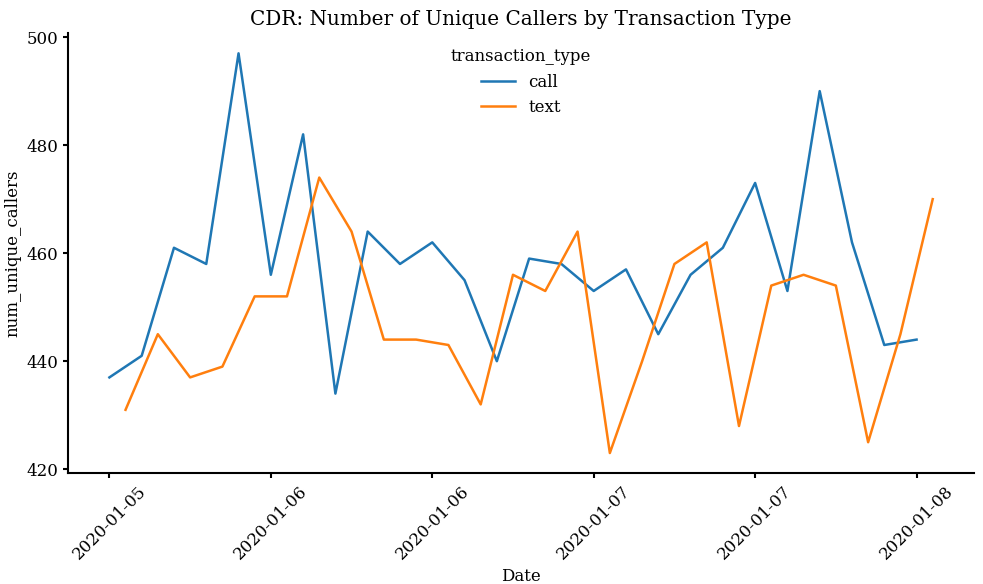

In [12]:
# Plot diagnostics
fig = plot_timeseries_diagnostics(
    cdr_timeseries_diagnostics,
    value_column="num_unique_callers",
    groupby_column="transaction_type",
    plot_title="CDR: Number of Unique Callers by Transaction Type"
    )
plt.show()

In [13]:
# Identify daytime and weekend calls

# Preprocessing steps with new code
cdr_spark = spark.createDataFrame(cdr_filtered) 
cdr_spark_with_daytime = identify_daytime(cdr_spark)
cdr_spark_with_weekend = identify_weekend(cdr_spark_with_daytime)

# Swap caller and recipient to get recipient-centric view
cdr_swapped_caller_recipient = swap_caller_and_recipient(cdr_spark_with_weekend) 

# Identify and tag conversations
cdr_tagged_conversations = identify_and_tag_conversations(cdr_swapped_caller_recipient, max_wait=3600)

pd_cdr_with_conversations = cdr_tagged_conversations.toPandas()

# Change tagged conversaton columns for old featurization code
old_pd_cdr_with_conversations = pd_cdr_with_conversations.rename(columns={
    "transaction_type": "txn_type",
    "caller_antenna_id": "caller_antenna",
    "recipient_antenna_id": "recipient_antenna",
    "is_daytime": "daytime",
    "is_weekend": "weekday",
    "direction_of_transaction": "direction",
    "time_lapse": "wait"
    })
old_pd_cdr_with_conversations["daytime"] = old_pd_cdr_with_conversations["daytime"].map({1: "day", 0: "night"})
old_pd_cdr_with_conversations["weekday"] = old_pd_cdr_with_conversations["weekday"].map({1: "weekend", 0: "weekday"})
old_pd_cdr_with_conversations["direction"] = old_pd_cdr_with_conversations["direction"].map({"outgoing": "out", "incoming": "in"})
# Convert conversation timestamp to Unix epoch (long) in pandas, handling NaT
# old_pd_cdr_with_conversations["conversation"] = pd.to_datetime(old_pd_cdr_with_conversations["conversation"]).astype('int64') / 10**9
# Replace NaN with None for Spark compatibility
# old_pd_cdr_with_conversations.loc[
#     old_pd_cdr_with_conversations.conversation.isna(),
#     "conversation"] = None


old_spark_cdr_with_conversations = spark.createDataFrame(old_pd_cdr_with_conversations)


In [ ]:
# Featurize data

In [ ]:
# Get number of active days

# New code
cdr_active_days = get_active_days(cdr_tagged_conversations)
pd_cdr_active_days = cdr_active_days.toPandas()

# Old code
old_cdr_active_days = active_days(old_spark_cdr_with_conversations)
pd_old_cdr_active_days = old_cdr_active_days.toPandas()

# Rename columns to match and prep for comparison
pd_old_cdr_active_days.rename(columns={
    "active_days_allweek_allday": "active_days_all",
    "active_days_allweek_day": "active_days_day",
    "active_days_allweek_night": "active_days_night",
    "active_days_weekend_allday": "active_days_weekend",
    "active_days_weekday_allday": "active_days_weekday",
}, inplace=True)
merge_active_days = pd_cdr_active_days.merge(
    pd_old_cdr_active_days,
    on="caller_id",
    how="outer",
)

check_columns_data(merge_active_days, pd_cdr_active_days.columns.tolist())


In [ ]:
# Get number of contacts per caller

# New code
cdr_number_of_contacts_per_caller = get_number_of_contacts_per_caller(
    cdr_tagged_conversations)

# Old code
old_cdr_number_of_contacts_per_caller = number_of_contacts(old_spark_cdr_with_conversations)

# Rename columns to match and prep for comparison
pd_cdr_number_of_contacts_per_caller = cdr_number_of_contacts_per_caller.toPandas()
pd_old_cdr_number_of_contacts_per_caller = old_cdr_number_of_contacts_per_caller.toPandas()
pd_old_cdr_number_of_contacts_per_caller.rename(columns={
    'number_of_contacts_allweek_allday_call': 'call_num_unique_contacts',
    'number_of_contacts_allweek_allday_text': 'text_num_unique_contacts',
    'number_of_contacts_allweek_day_call': 'daytime_call_num_unique_contacts',
    'number_of_contacts_allweek_day_text': 'daytime_text_num_unique_contacts',
    'number_of_contacts_allweek_night_call': 'nighttime_call_num_unique_contacts',
    'number_of_contacts_allweek_night_text': 'nighttime_text_num_unique_contacts',
    'number_of_contacts_weekday_allday_call': 'weekday_call_num_unique_contacts',
    'number_of_contacts_weekday_allday_text': 'weekday_text_num_unique_contacts',
    'number_of_contacts_weekday_day_call': 'weekday_daytime_call_num_unique_contacts',
    'number_of_contacts_weekday_day_text': 'weekday_daytime_text_num_unique_contacts',
    'number_of_contacts_weekday_night_call': 'weekday_nighttime_call_num_unique_contacts',
    'number_of_contacts_weekday_night_text': 'weekday_nighttime_text_num_unique_contacts',
    'number_of_contacts_weekend_allday_call': 'weekend_call_num_unique_contacts',
    'number_of_contacts_weekend_allday_text': 'weekend_text_num_unique_contacts',
    'number_of_contacts_weekend_day_call': 'weekend_daytime_call_num_unique_contacts',
    'number_of_contacts_weekend_day_text': 'weekend_daytime_text_num_unique_contacts',
    'number_of_contacts_weekend_night_call': 'weekend_nighttime_call_num_unique_contacts',
    'number_of_contacts_weekend_night_text': 'weekend_nighttime_text_num_unique_contacts',
  }
, inplace=True)
merge_number_of_contacts = cdr_number_of_contacts_per_caller.toPandas().merge(
    pd_old_cdr_number_of_contacts_per_caller,
    on="caller_id",
    how="outer",
)

# Check cols
false_cols = check_columns_data(merge_number_of_contacts, pd_cdr_number_of_contacts_per_caller.columns.tolist())

# Some cols don't match because new code counts unique contacts even if they had 0 interactions
# in that category, whereas old code only counts contacts with >0 interactions in that category
# so check that when they differ, the new code has 0s and old code has NaNs
for false_col in false_cols:
    print(false_col)
    print((merge_number_of_contacts.loc[merge_number_of_contacts[false_col + "_x"] != merge_number_of_contacts[false_col + "_y"], 
                         false_col + "_x"] == 0).all())
    print(merge_number_of_contacts.loc[merge_number_of_contacts[false_col + "_x"] != merge_number_of_contacts[false_col + "_y"], 
                            false_col + "_y"].isna().all())
    print("\n")


In [ ]:
# Get call duration stats

# New code
cdr_call_duration_stats = get_call_duration_stats(cdr_tagged_conversations)
pd_cdr_call_duration_stats = cdr_call_duration_stats.toPandas()

# Old code
old_cdr_call_duration_stats = call_duration(old_spark_cdr_with_conversations)
pd_old_cdr_call_duration_stats = old_cdr_call_duration_stats.toPandas()

# Rename columns to match and prep for comparison
pd_old_cdr_call_duration_stats.rename(columns={
    'call_duration_allweek_allday_call_mean': 'mean_duration',
    'call_duration_allweek_allday_call_std': 'std_duration',
    'call_duration_allweek_allday_call_median': 'median_duration',
    'call_duration_allweek_allday_call_skewness': 'skewness_duration',
    'call_duration_allweek_allday_call_kurtosis': 'kurtosis_duration',
    'call_duration_allweek_allday_call_min': 'min_duration',
    'call_duration_allweek_allday_call_max': 'max_duration',
    'call_duration_allweek_day_call_mean': 'daytime_mean_duration',
    'call_duration_allweek_day_call_std': 'daytime_std_duration',
    'call_duration_allweek_day_call_median': 'daytime_median_duration',
    'call_duration_allweek_day_call_skewness': 'daytime_skewness_duration',
    'call_duration_allweek_day_call_kurtosis': 'daytime_kurtosis_duration',
    'call_duration_allweek_day_call_min': 'daytime_min_duration',
    'call_duration_allweek_day_call_max': 'daytime_max_duration',
    'call_duration_allweek_night_call_mean': 'nighttime_mean_duration',
    'call_duration_allweek_night_call_std': 'nighttime_std_duration',
    'call_duration_allweek_night_call_median': 'nighttime_median_duration',
    'call_duration_allweek_night_call_skewness': 'nighttime_skewness_duration',
    'call_duration_allweek_night_call_kurtosis': 'nighttime_kurtosis_duration',
    'call_duration_allweek_night_call_min': 'nighttime_min_duration',
    'call_duration_allweek_night_call_max': 'nighttime_max_duration',
    'call_duration_weekday_allday_call_mean': 'weekday_mean_duration',
    'call_duration_weekday_allday_call_std': 'weekday_std_duration',
    'call_duration_weekday_allday_call_median': 'weekday_median_duration',
    'call_duration_weekday_allday_call_skewness': 'weekday_skewness_duration',
    'call_duration_weekday_allday_call_kurtosis': 'weekday_kurtosis_duration',
    'call_duration_weekday_allday_call_min': 'weekday_min_duration',
    'call_duration_weekday_allday_call_max': 'weekday_max_duration',
    'call_duration_weekday_day_call_mean': 'weekday_daytime_mean_duration' ,
    'call_duration_weekday_day_call_std': 'weekday_daytime_std_duration',
    'call_duration_weekday_day_call_median': 'weekday_daytime_median_duration',
    'call_duration_weekday_day_call_skewness': 'weekday_daytime_skewness_duration',
    'call_duration_weekday_day_call_kurtosis': 'weekday_daytime_kurtosis_duration',
    'call_duration_weekday_day_call_min': 'weekday_daytime_min_duration',
    'call_duration_weekday_day_call_max': 'weekday_daytime_max_duration',
    'call_duration_weekday_night_call_mean': 'weekday_nighttime_mean_duration',
    'call_duration_weekday_night_call_std': 'weekday_nighttime_std_duration',
    'call_duration_weekday_night_call_median': 'weekday_nighttime_median_duration',
    'call_duration_weekday_night_call_skewness': 'weekday_nighttime_skewness_duration',
    'call_duration_weekday_night_call_kurtosis': 'weekday_nighttime_kurtosis_duration',
    'call_duration_weekday_night_call_min': 'weekday_nighttime_min_duration',
    'call_duration_weekday_night_call_max': 'weekday_nighttime_max_duration',
    'call_duration_weekend_allday_call_mean': 'weekend_mean_duration',
    'call_duration_weekend_allday_call_std': 'weekend_std_duration',
    'call_duration_weekend_allday_call_median': 'weekend_median_duration',
    'call_duration_weekend_allday_call_skewness': 'weekend_skewness_duration',
    'call_duration_weekend_allday_call_kurtosis': 'weekend_kurtosis_duration',
    'call_duration_weekend_allday_call_min': 'weekend_min_duration',
    'call_duration_weekend_allday_call_max': 'weekend_max_duration',
    'call_duration_weekend_day_call_mean': 'weekend_daytime_mean_duration',
    'call_duration_weekend_day_call_std': 'weekend_daytime_std_duration',
    'call_duration_weekend_day_call_median': 'weekend_daytime_median_duration',
    'call_duration_weekend_day_call_skewness': 'weekend_daytime_skewness_duration',
    'call_duration_weekend_day_call_kurtosis': 'weekend_daytime_kurtosis_duration',
    'call_duration_weekend_day_call_min': 'weekend_daytime_min_duration',
    'call_duration_weekend_day_call_max': 'weekend_daytime_max_duration',
    'call_duration_weekend_night_call_mean': 'weekend_nighttime_mean_duration',
    'call_duration_weekend_night_call_std': 'weekend_nighttime_std_duration',
    'call_duration_weekend_night_call_median': 'weekend_nighttime_median_duration',
    'call_duration_weekend_night_call_skewness': 'weekend_nighttime_skewness_duration',
    'call_duration_weekend_night_call_kurtosis': 'weekend_nighttime_kurtosis_duration',
    'call_duration_weekend_night_call_min': 'weekend_nighttime_min_duration',
    'call_duration_weekend_night_call_max': 'weekend_nighttime_max_duration'
}, inplace=True)

merge_call_duration = pd_cdr_call_duration_stats.merge(
    pd_old_cdr_call_duration_stats,
    on="caller_id",
    how="outer",
)
false_cols = check_columns_data(
    merge_call_duration, 
    pd_cdr_call_duration_stats.columns.tolist()
)

for false_col in false_cols:
    print(false_col)
    print((merge_call_duration.loc[
        merge_call_duration[false_col + "_x"].round(3) != merge_call_duration[false_col + "_y"].round(3),
        false_col + "_x"] == 0.).all())
    print((merge_call_duration.loc[
        merge_call_duration[false_col + "_x"].round(3) != merge_call_duration[false_col + "_y"].round(3),
        false_col + "_y"].isna()).all())    


In [ ]:
# Get percentage of nocturnal calls

# New code
cdr_nocturnal_calls = get_percentage_of_nocturnal_interactions(cdr_tagged_conversations)
pd_cdr_nocturnal_calls = cdr_nocturnal_calls.toPandas()

# Old code
old_cdr_nocturnal_calls = percent_nocturnal(old_spark_cdr_with_conversations)
pd_old_cdr_nocturnal_calls = old_cdr_nocturnal_calls.toPandas()

# Rename columns to match and prep for comparison
pd_old_cdr_nocturnal_calls.rename(columns={
    'percent_nocturnal_allweek_text': 'text_percentage_nocturnal_interactions',
    'percent_nocturnal_allweek_call': 'call_percentage_nocturnal_interactions',
    'percent_nocturnal_weekday_text': 'weekday_text_percentage_nocturnal_interactions',
    'percent_nocturnal_weekday_call': 'weekday_call_percentage_nocturnal_interactions',
    'percent_nocturnal_weekend_text': 'weekend_text_percentage_nocturnal_interactions',
    'percent_nocturnal_weekend_call': 'weekend_call_percentage_nocturnal_interactions',
}, inplace=True)

merge_nocturnal_calls = pd_cdr_nocturnal_calls.merge(
    pd_old_cdr_nocturnal_calls,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_nocturnal_calls, pd_cdr_nocturnal_calls.columns)

for false_col in false_cols:
    print(false_col)
    print((merge_nocturnal_calls.loc[merge_nocturnal_calls[false_col + "_x"] != merge_nocturnal_calls[false_col + "_y"], 
                         [false_col + "_x", false_col + "_y"]]))
    print("\n")


In [ ]:
# Get percentage of initiated conversations

# New code
cdr_percentage_initiated_conversations = get_percentage_of_initiated_conversations(cdr_tagged_conversations)
pd_cdr_initiated_conversations = cdr_percentage_initiated_conversations.toPandas()

# Old code
old_cdr_percentage_initiated_conversations = percent_initiated_conversations(old_spark_cdr_with_conversations)
pd_old_cdr_initiated_conversations = old_cdr_percentage_initiated_conversations.toPandas()

pd_old_cdr_initiated_conversations.columns, pd_cdr_initiated_conversations.columns
# Rename columns to match and prep for comparison
pd_old_cdr_initiated_conversations.rename(columns={
    'percent_initiated_conversations_allweek_allday': 'percentage_initiated_conversations',
    'percent_initiated_conversations_allweek_day': 'daytime_percentage_initiated_conversations',
    'percent_initiated_conversations_allweek_night': 'nighttime_percentage_initiated_conversations',
    'percent_initiated_conversations_weekday_allday': 'weekday_percentage_initiated_conversations',
    'percent_initiated_conversations_weekday_day': 'weekday_daytime_percentage_initiated_conversations',
    'percent_initiated_conversations_weekday_night': 'weekday_nighttime_percentage_initiated_conversations',
    'percent_initiated_conversations_weekend_allday': 'weekend_percentage_initiated_conversations',
    'percent_initiated_conversations_weekend_day': 'weekend_daytime_percentage_initiated_conversations',
    'percent_initiated_conversations_weekend_night': 'weekend_nighttime_percentage_initiated_conversations',
}, inplace=True)

merge_initiated_conversations = pd_cdr_initiated_conversations.merge(
    pd_old_cdr_initiated_conversations,
    on="caller_id",
    how="outer",
)


false_cols = check_columns_data(merge_initiated_conversations, pd_cdr_initiated_conversations.columns)

# Some cols don't match because new code counts unique contacts even if they had 0 interactions
# in that category, whereas old code only counts contacts with >0 interactions in that category
# so check that when they differ, the new code has 0s and old code has NaNs
for false_col in false_cols:
    print(false_col)
    print((merge_initiated_conversations.loc[merge_initiated_conversations[false_col + "_x"] != merge_initiated_conversations[false_col + "_y"], 
                         false_col + "_x"] == 0).all())
    print(merge_initiated_conversations.loc[merge_initiated_conversations[false_col + "_x"] != merge_initiated_conversations[false_col + "_y"], 
                            false_col + "_y"].isna().all())
    print("\n")

In [ ]:
# Get percentage of initiated calls

# New code
cdr_percentage_initiated_calls = get_percentage_of_initiated_calls(cdr_tagged_conversations)
pd_cdr_initiated_calls = cdr_percentage_initiated_calls.toPandas()

# Old code
old_cdr_percentage_initiated_calls = percent_initiated_interactions(old_spark_cdr_with_conversations)
pd_old_cdr_initiated_calls = old_cdr_percentage_initiated_calls.toPandas()


# Prepare for comparison
pd_old_cdr_initiated_calls.rename(columns={
    'percent_initiated_interactions_allweek_allday': 'percentage_initiated_calls',
    'percent_initiated_interactions_allweek_day': 'daytime_percentage_initiated_calls',
    'percent_initiated_interactions_allweek_night': 'nighttime_percentage_initiated_calls',
    'percent_initiated_interactions_weekday_allday': 'weekday_percentage_initiated_calls',
    'percent_initiated_interactions_weekend_allday': 'weekend_percentage_initiated_calls',
    'percent_initiated_interactions_weekday_day': 'weekday_daytime_percentage_initiated_calls',
    'percent_initiated_interactions_weekday_night': 'weekday_nighttime_percentage_initiated_calls',
    'percent_initiated_interactions_weekend_day': 'weekend_daytime_percentage_initiated_calls',
    'percent_initiated_interactions_weekend_night': 'weekend_nighttime_percentage_initiated_calls',
}, inplace=True)

merge_initiated_calls = pd_cdr_initiated_calls.merge(
    pd_old_cdr_initiated_calls,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_initiated_calls, pd_cdr_initiated_calls.columns)
for false_col in false_cols:
    print(false_col)
    print((merge_initiated_calls.loc[merge_initiated_calls[false_col + "_x"] != merge_initiated_calls[false_col + "_y"], 
                         false_col + "_x"] == 0).all())
    print(merge_initiated_calls.loc[merge_initiated_calls[false_col + "_x"] != merge_initiated_calls[false_col + "_y"], 
                            false_col + "_y"].isna().all())
    print("\n")


In [ ]:
# Get text response time statistics
# New code
cdr_text_response_time_delay_stats = get_text_response_time_delay_stats(cdr_tagged_conversations)
pd_cdr_text_response_time_delay_stats = cdr_text_response_time_delay_stats.toPandas()

# Old code
old_cdr_text_response_time_delay_stats = response_delay_text(old_spark_cdr_with_conversations)
old_pd_cdr_text_response_time_delay_stats = old_cdr_text_response_time_delay_stats.toPandas()


# Prepare for comparison
old_pd_cdr_text_response_time_delay_stats.rename(columns={
    'response_delay_text_allweek_allday_mean': 'mean_response_time_delay',
    'response_delay_text_allweek_allday_std': 'std_response_time_delay',
    'response_delay_text_allweek_allday_median': 'median_response_time_delay',
    'response_delay_text_allweek_allday_skewness': 'skewness_response_time_delay',
    'response_delay_text_allweek_allday_kurtosis': 'kurtosis_response_time_delay',
    'response_delay_text_allweek_allday_min': 'min_response_time_delay',
    'response_delay_text_allweek_allday_max': 'max_response_time_delay',
    'response_delay_text_allweek_day_mean': 'daytime_mean_response_time_delay',
    'response_delay_text_allweek_day_std': 'daytime_std_response_time_delay',
    'response_delay_text_allweek_day_median': 'daytime_median_response_time_delay',
    'response_delay_text_allweek_day_skewness': 'daytime_skewness_response_time_delay',
    'response_delay_text_allweek_day_kurtosis': 'daytime_kurtosis_response_time_delay',
    'response_delay_text_allweek_day_min': 'daytime_min_response_time_delay',
    'response_delay_text_allweek_day_max': 'daytime_max_response_time_delay',
    'response_delay_text_allweek_night_mean': 'nighttime_mean_response_time_delay',
    'response_delay_text_allweek_night_std': 'nighttime_std_response_time_delay',
    'response_delay_text_allweek_night_median': 'nighttime_median_response_time_delay',
    'response_delay_text_allweek_night_skewness': 'nighttime_skewness_response_time_delay',
    'response_delay_text_allweek_night_kurtosis': 'nighttime_kurtosis_response_time_delay',
    'response_delay_text_allweek_night_min': 'nighttime_min_response_time_delay',
    'response_delay_text_allweek_night_max': 'nighttime_max_response_time_delay',
    'response_delay_text_weekday_allday_mean': 'weekday_mean_response_time_delay',
    'response_delay_text_weekday_allday_std': 'weekday_std_response_time_delay',
    'response_delay_text_weekday_allday_median': 'weekday_median_response_time_delay',
    'response_delay_text_weekday_allday_skewness': 'weekday_skewness_response_time_delay',
    'response_delay_text_weekday_allday_kurtosis': 'weekday_kurtosis_response_time_delay',
    'response_delay_text_weekday_allday_min': 'weekday_min_response_time_delay',
    'response_delay_text_weekday_allday_max': 'weekday_max_response_time_delay',
    'response_delay_text_weekend_allday_mean': 'weekend_mean_response_time_delay',
    'response_delay_text_weekend_allday_std': 'weekend_std_response_time_delay',
    'response_delay_text_weekend_allday_median': 'weekend_median_response_time_delay',
    'response_delay_text_weekend_allday_skewness': 'weekend_skewness_response_time_delay',
    'response_delay_text_weekend_allday_kurtosis': 'weekend_kurtosis_response_time_delay',
    'response_delay_text_weekend_allday_min': 'weekend_min_response_time_delay',
    'response_delay_text_weekend_allday_max': 'weekend_max_response_time_delay',
    'response_delay_text_weekday_day_mean': 'weekday_daytime_mean_response_time_delay',
    'response_delay_text_weekday_day_std': 'weekday_daytime_std_response_time_delay',
    'response_delay_text_weekday_day_median': 'weekday_daytime_median_response_time_delay',
    'response_delay_text_weekday_day_skewness': 'weekday_daytime_skewness_response_time_delay',
    'response_delay_text_weekday_day_kurtosis': 'weekday_daytime_kurtosis_response_time_delay',
    'response_delay_text_weekday_day_min': 'weekday_daytime_min_response_time_delay',
    'response_delay_text_weekday_day_max': 'weekday_daytime_max_response_time_delay',
    'response_delay_text_weekday_night_mean': 'weekday_nighttime_mean_response_time_delay',
    'response_delay_text_weekday_night_std': 'weekday_nighttime_std_response_time_delay',
    'response_delay_text_weekday_night_median': 'weekday_nighttime_median_response_time_delay',
    'response_delay_text_weekday_night_skewness': 'weekday_nighttime_skewness_response_time_delay',
    'response_delay_text_weekday_night_kurtosis': 'weekday_nighttime_kurtosis_response_time_delay',
    'response_delay_text_weekday_night_min': 'weekday_nighttime_min_response_time_delay',
    'response_delay_text_weekday_night_max': 'weekday_nighttime_max_response_time_delay',
    'response_delay_text_weekend_day_mean': 'weekend_daytime_mean_response_time_delay',
    'response_delay_text_weekend_day_std': 'weekend_daytime_std_response_time_delay',
    'response_delay_text_weekend_day_median': 'weekend_daytime_median_response_time_delay',
    'response_delay_text_weekend_day_skewness': 'weekend_daytime_skewness_response_time_delay',
    'response_delay_text_weekend_day_kurtosis': 'weekend_daytime_kurtosis_response_time_delay',
    'response_delay_text_weekend_day_min': 'weekend_daytime_min_response_time_delay',
    'response_delay_text_weekend_day_max': 'weekend_daytime_max_response_time_delay',
    'response_delay_text_weekend_night_mean': 'weekend_nighttime_mean_response_time_delay',
    'response_delay_text_weekend_night_std': 'weekend_nighttime_std_response_time_delay',
    'response_delay_text_weekend_night_median': 'weekend_nighttime_median_response_time_delay',
    'response_delay_text_weekend_night_skewness': 'weekend_nighttime_skewness_response_time_delay',
    'response_delay_text_weekend_night_kurtosis': 'weekend_nighttime_kurtosis_response_time_delay',
    'response_delay_text_weekend_night_min': 'weekend_nighttime_min_response_time_delay',
    'response_delay_text_weekend_night_max': 'weekend_nighttime_max_response_time_delay',
}, inplace=True)

merge_text_response_delay = pd_cdr_text_response_time_delay_stats.merge(
    old_pd_cdr_text_response_time_delay_stats,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_text_response_delay, pd_cdr_text_response_time_delay_stats.columns)
for false_col in false_cols:
    print(false_col)
    print((merge_text_response_delay.loc[merge_text_response_delay[false_col + "_x"] != merge_text_response_delay[false_col + "_y"], 
                         false_col + "_x"] == 0).all())
    print(merge_text_response_delay.loc[merge_text_response_delay[false_col + "_x"] != merge_text_response_delay[false_col + "_y"], 
                            false_col + "_y"].isna().all())
    print("\n")

In [ ]:
# Get text response rate

# New code
cdr_text_response_rate = get_text_response_rate(cdr_tagged_conversations)
pd_cdr_text_response_rate = cdr_text_response_rate.toPandas()

# Old code
old_cdr_text_response_rate = response_rate_text(old_spark_cdr_with_conversations)
old_pd_cdr_text_response_rate = old_cdr_text_response_rate.toPandas()

# Prepare for comparison
old_pd_cdr_text_response_rate.rename(columns={
    'response_rate_text_allweek_allday': 'text_response_rate',
    'response_rate_text_allweek_day': 'daytime_text_response_rate',
    'response_rate_text_allweek_night': 'nighttime_text_response_rate',
    'response_rate_text_weekday_allday': 'weekday_text_response_rate',
    'response_rate_text_weekday_day': 'weekday_daytime_text_response_rate',
    'response_rate_text_weekday_night': 'weekday_nighttime_text_response_rate',
    'response_rate_text_weekend_allday': 'weekend_text_response_rate',
    'response_rate_text_weekend_day': 'weekend_daytime_text_response_rate',
    'response_rate_text_weekend_night': 'weekend_nighttime_text_response_rate',
}, inplace=True)

merge_text_response_rate = pd_cdr_text_response_rate.merge(
    old_pd_cdr_text_response_rate,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_text_response_rate, pd_cdr_text_response_rate.columns)

for false_col in false_cols:
    print(false_col)
    print((merge_text_response_rate.loc[
                merge_text_response_rate[false_col + "_x"] != merge_text_response_rate[false_col + "_y"], 
                false_col + "_x"
                ] == 0).all())
    print((merge_text_response_rate.loc[
                merge_text_response_rate[false_col + "_x"] != merge_text_response_rate[false_col + "_y"], 
                false_col + "_y"
                ].isna()).all())
    
    print("\n")

In [ ]:
# Get entropy of interactions per caller

# New code
cdr_entropy_of_interactions = get_entropy_of_interactions_per_caller(cdr_tagged_conversations)
pd_cdr_entropy_of_interactions = cdr_entropy_of_interactions.toPandas()

# Old code
old_cdr_entropy_of_interactions = entropy_of_contacts(old_spark_cdr_with_conversations)
old_pd_cdr_entropy_of_interactions = old_cdr_entropy_of_interactions.toPandas()

# Prepare for comparison
old_pd_cdr_entropy_of_interactions.rename(columns={
    'entropy_of_contacts_allweek_allday_call': 'call_entropy_of_interactions',
    'entropy_of_contacts_allweek_allday_text': 'text_entropy_of_interactions',
    'entropy_of_contacts_allweek_day_call': 'daytime_call_entropy_of_interactions',
    'entropy_of_contacts_allweek_day_text': 'daytime_text_entropy_of_interactions',
    'entropy_of_contacts_allweek_night_call': 'nighttime_call_entropy_of_interactions',
    'entropy_of_contacts_allweek_night_text': 'nighttime_text_entropy_of_interactions',
    'entropy_of_contacts_weekday_allday_call': 'weekday_call_entropy_of_interactions',
    'entropy_of_contacts_weekday_allday_text': 'weekday_text_entropy_of_interactions',
    'entropy_of_contacts_weekday_day_call': 'weekday_daytime_call_entropy_of_interactions',
    'entropy_of_contacts_weekday_day_text': 'weekday_daytime_text_entropy_of_interactions',
    'entropy_of_contacts_weekday_night_call': 'weekday_nighttime_call_entropy_of_interactions',
    'entropy_of_contacts_weekday_night_text': 'weekday_nighttime_text_entropy_of_interactions',
    'entropy_of_contacts_weekend_allday_call': 'weekend_call_entropy_of_interactions',
    'entropy_of_contacts_weekend_allday_text': 'weekend_text_entropy_of_interactions',
    'entropy_of_contacts_weekend_day_call': 'weekend_daytime_call_entropy_of_interactions',
    'entropy_of_contacts_weekend_day_text': 'weekend_daytime_text_entropy_of_interactions',
    'entropy_of_contacts_weekend_night_call': 'weekend_nighttime_call_entropy_of_interactions',
    'entropy_of_contacts_weekend_night_text': 'weekend_nighttime_text_entropy_of_interactions',
}, inplace=True)

merge_entropy_of_interactions = pd_cdr_entropy_of_interactions.merge(
    old_pd_cdr_entropy_of_interactions,
    on="caller_id",
    how="outer",
)
false_cols = check_columns_data(
    merge_entropy_of_interactions, 
    pd_cdr_entropy_of_interactions.columns)

for false_col in false_cols:
    print(false_col)
    print((merge_entropy_of_interactions.loc[
        merge_entropy_of_interactions[false_col + "_x"] != merge_entropy_of_interactions[false_col + "_y"],
        false_col + "_x"] == 0.).all())
    print((merge_entropy_of_interactions.loc[
        merge_entropy_of_interactions[false_col + "_x"] != merge_entropy_of_interactions[false_col + "_y"],
        false_col + "_y"].isna()).all())


In [ ]:
# Get fraction of outgoing calls

# New code
cdr_fraction_of_outgoing_calls = get_outgoing_interaction_fraction_stats(cdr_tagged_conversations)
pd_cdr_fraction_of_outgoing_calls = cdr_fraction_of_outgoing_calls.toPandas()

# Old code
old_cdr_fraction_of_outgoing_calls = balance_of_contacts(old_spark_cdr_with_conversations)
old_pd_cdr_fraction_of_outgoing_calls = old_cdr_fraction_of_outgoing_calls.toPandas()

# Prepare for comparison
dictionary = {
    "allweek": "",
}
old_pd_cdr_fraction_of_outgoing_calls.rename(columns={
    "balance_of_contacts_allweek_allday_call_mean": "call_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_std": "call_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_median": "call_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_skewness": "call_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_kurtosis": "call_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_min": "call_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_call_max": "call_max_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_mean": "text_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_std": "text_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_median": "text_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_skewness": "text_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_kurtosis": "text_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_min": "text_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_allday_text_max": "text_max_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_mean": "call_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_std": "call_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_median": "call_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_skewness": "call_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_kurtosis": "call_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_min": "call_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_call_max": "call_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_mean": "text_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_std": "text_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_median": "text_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_skewness": "text_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_kurtosis": "text_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_min": "text_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_day_text_max": "text_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_mean": "call_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_std": "call_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_median": "call_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_skewness": "call_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_kurtosis": "call_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_min": "call_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_call_max": "call_nighttime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_mean": "text_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_std": "text_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_median": "text_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_skewness": "text_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_kurtosis": "text_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_min": "text_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_allweek_night_text_max": "text_nighttime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_mean": "call_weekday_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_std": "call_weekday_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_median": "call_weekday_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_skewness": "call_weekday_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_kurtosis": "call_weekday_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_min": "call_weekday_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_call_max": "call_weekday_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_mean": "text_weekday_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_std": "text_weekday_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_median": "text_weekday_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_skewness": "text_weekday_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_kurtosis": "text_weekday_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_min": "text_weekday_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_allday_text_max": "text_weekday_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_mean": "call_weekend_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_std": "call_weekend_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_median": "call_weekend_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_skewness": "call_weekend_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_kurtosis": "call_weekend_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_min": "call_weekend_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_call_max": "call_weekend_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_mean": "text_weekend_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_std": "text_weekend_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_median": "text_weekend_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_skewness": "text_weekend_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_kurtosis": "text_weekend_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_min": "text_weekend_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_allday_text_max": "text_weekend_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_mean": "call_weekday_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_std": "call_weekday_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_median": "call_weekday_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_skewness": "call_weekday_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_kurtosis": "call_weekday_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_min": "call_weekday_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_call_max": "call_weekday_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_mean": "text_weekday_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_std": "text_weekday_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_median": "text_weekday_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_skewness": "text_weekday_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_kurtosis": "text_weekday_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_min": "text_weekday_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_day_text_max": "text_weekday_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_mean": "call_weekday_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_std": "call_weekday_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_median": "call_weekday_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_skewness": "call_weekday_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_kurtosis": "call_weekday_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_min": "call_weekday_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_call_max": "call_weekday_nighttime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_mean": "text_weekday_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_std": "text_weekday_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_median": "text_weekday_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_skewness": "text_weekday_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_kurtosis": "text_weekday_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_min": "text_weekday_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekday_night_text_max": "text_weekday_nighttime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_mean": "call_weekend_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_std": "call_weekend_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_median": "call_weekend_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_skewness": "call_weekend_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_kurtosis": "call_weekend_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_min": "call_weekend_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_call_max": "call_weekend_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_mean": "text_weekend_daytime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_std": "text_weekend_daytime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_median": "text_weekend_daytime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_skewness": "text_weekend_daytime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_kurtosis": "text_weekend_daytime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_min": "text_weekend_daytime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_day_text_max": "text_weekend_daytime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_mean": "call_weekend_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_std": "call_weekend_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_median": "call_weekend_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_skewness": "call_weekend_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_kurtosis": "call_weekend_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_min": "call_weekend_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_call_max": "call_weekend_nighttime_max_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_mean": "text_weekend_nighttime_mean_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_std": "text_weekend_nighttime_std_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_median": "text_weekend_nighttime_median_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_skewness": "text_weekend_nighttime_skewness_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_kurtosis": "text_weekend_nighttime_kurtosis_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_min": "text_weekend_nighttime_min_fraction_of_outgoing_calls",
    "balance_of_contacts_weekend_night_text_max": "text_weekend_nighttime_max_fraction_of_outgoing_calls",
}, inplace=True)

merge_fraction_of_outgoing_calls = pd_cdr_fraction_of_outgoing_calls.merge(
    old_pd_cdr_fraction_of_outgoing_calls,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_fraction_of_outgoing_calls, 
    pd_cdr_fraction_of_outgoing_calls.columns)

# The two columns seem to be equal in cases where there are no zeros / NaNs. Not sure why check_colmns_data isn't picking up on it
for false_col in false_cols:
    print(false_col)
    print(
        (merge_fraction_of_outgoing_calls.loc[
            merge_fraction_of_outgoing_calls[false_col + "_x"] != merge_fraction_of_outgoing_calls[false_col + "_y"],
            false_col + "_x"
        ] == 0.).all()
    )
    print(
        (merge_fraction_of_outgoing_calls.loc[
            merge_fraction_of_outgoing_calls[false_col + "_x"] != merge_fraction_of_outgoing_calls[false_col + "_y"],
            false_col + "_y"
        ].isna()).all()
    )
    print(
        merge_fraction_of_outgoing_calls.loc[
            merge_fraction_of_outgoing_calls[false_col + "_x"] != merge_fraction_of_outgoing_calls[false_col + "_y"],
            [false_col + "_x", false_col + "_y"]
        ]
    )
    print("\n")


In [63]:
# Get interaction stats per caller

# New code
cdr_interaction_stats_per_caller = get_interaction_stats_per_caller(cdr_tagged_conversations)
pd_cdr_interaction_stats_per_caller = cdr_interaction_stats_per_caller.toPandas()

# Old code
old_cdr_interaction_stats_per_caller = interactions_per_contact(old_spark_cdr_with_conversations)
old_pd_cdr_interaction_stats_per_caller = old_cdr_interaction_stats_per_caller.toPandas()

# Prepare for comparison
old_pd_cdr_interaction_stats_per_caller.rename(columns={
    # allweek_allday combinations (no time dimensions)
    'interactions_per_contact_allweek_allday_call_mean': 'call_mean_interaction_count',
    'interactions_per_contact_allweek_allday_call_min': 'call_min_interaction_count',
    'interactions_per_contact_allweek_allday_call_max': 'call_max_interaction_count',
    'interactions_per_contact_allweek_allday_call_std': 'call_std_interaction_count',
    'interactions_per_contact_allweek_allday_call_median': 'call_median_interaction_count',
    'interactions_per_contact_allweek_allday_call_skewness': 'call_skewness_interaction_count',
    'interactions_per_contact_allweek_allday_call_kurtosis': 'call_kurtosis_interaction_count',
    'interactions_per_contact_allweek_allday_text_mean': 'text_mean_interaction_count',
    'interactions_per_contact_allweek_allday_text_min': 'text_min_interaction_count',
    'interactions_per_contact_allweek_allday_text_max': 'text_max_interaction_count',
    'interactions_per_contact_allweek_allday_text_std': 'text_std_interaction_count',
    'interactions_per_contact_allweek_allday_text_median': 'text_median_interaction_count',
    'interactions_per_contact_allweek_allday_text_skewness': 'text_skewness_interaction_count',
    'interactions_per_contact_allweek_allday_text_kurtosis': 'text_kurtosis_interaction_count',
    
    # allweek_day combinations (only daytime dimension)
    'interactions_per_contact_allweek_day_call_mean': 'call_daytime_mean_interaction_count',
    'interactions_per_contact_allweek_day_call_min': 'call_daytime_min_interaction_count',
    'interactions_per_contact_allweek_day_call_max': 'call_daytime_max_interaction_count',
    'interactions_per_contact_allweek_day_call_std': 'call_daytime_std_interaction_count',
    'interactions_per_contact_allweek_day_call_median': 'call_daytime_median_interaction_count',
    'interactions_per_contact_allweek_day_call_skewness': 'call_daytime_skewness_interaction_count',
    'interactions_per_contact_allweek_day_call_kurtosis': 'call_daytime_kurtosis_interaction_count',
    'interactions_per_contact_allweek_day_text_mean': 'text_daytime_mean_interaction_count',
    'interactions_per_contact_allweek_day_text_min': 'text_daytime_min_interaction_count',
    'interactions_per_contact_allweek_day_text_max': 'text_daytime_max_interaction_count',
    'interactions_per_contact_allweek_day_text_std': 'text_daytime_std_interaction_count',
    'interactions_per_contact_allweek_day_text_median': 'text_daytime_median_interaction_count',
    'interactions_per_contact_allweek_day_text_skewness': 'text_daytime_skewness_interaction_count',
    'interactions_per_contact_allweek_day_text_kurtosis': 'text_daytime_kurtosis_interaction_count',
    
    # allweek_night combinations (only nighttime dimension)
    'interactions_per_contact_allweek_night_call_mean': 'call_nighttime_mean_interaction_count',
    'interactions_per_contact_allweek_night_call_min': 'call_nighttime_min_interaction_count',
    'interactions_per_contact_allweek_night_call_max': 'call_nighttime_max_interaction_count',
    'interactions_per_contact_allweek_night_call_std': 'call_nighttime_std_interaction_count',
    'interactions_per_contact_allweek_night_call_median': 'call_nighttime_median_interaction_count',
    'interactions_per_contact_allweek_night_call_skewness': 'call_nighttime_skewness_interaction_count',
    'interactions_per_contact_allweek_night_call_kurtosis': 'call_nighttime_kurtosis_interaction_count',
    'interactions_per_contact_allweek_night_text_mean': 'text_nighttime_mean_interaction_count',
    'interactions_per_contact_allweek_night_text_min': 'text_nighttime_min_interaction_count',
    'interactions_per_contact_allweek_night_text_max': 'text_nighttime_max_interaction_count',
    'interactions_per_contact_allweek_night_text_std': 'text_nighttime_std_interaction_count',
    'interactions_per_contact_allweek_night_text_median': 'text_nighttime_median_interaction_count',
    'interactions_per_contact_allweek_night_text_skewness': 'text_nighttime_skewness_interaction_count',
    'interactions_per_contact_allweek_night_text_kurtosis': 'text_nighttime_kurtosis_interaction_count',
    
    # weekday_allday combinations (only weekday dimension)
    'interactions_per_contact_weekday_allday_call_mean': 'call_weekday_mean_interaction_count',
    'interactions_per_contact_weekday_allday_call_min': 'call_weekday_min_interaction_count',
    'interactions_per_contact_weekday_allday_call_max': 'call_weekday_max_interaction_count',
    'interactions_per_contact_weekday_allday_call_std': 'call_weekday_std_interaction_count',
    'interactions_per_contact_weekday_allday_call_median': 'call_weekday_median_interaction_count',
    'interactions_per_contact_weekday_allday_call_skewness': 'call_weekday_skewness_interaction_count',
    'interactions_per_contact_weekday_allday_call_kurtosis': 'call_weekday_kurtosis_interaction_count',
    'interactions_per_contact_weekday_allday_text_mean': 'text_weekday_mean_interaction_count',
    'interactions_per_contact_weekday_allday_text_min': 'text_weekday_min_interaction_count',
    'interactions_per_contact_weekday_allday_text_max': 'text_weekday_max_interaction_count',
    'interactions_per_contact_weekday_allday_text_std': 'text_weekday_std_interaction_count',
    'interactions_per_contact_weekday_allday_text_median': 'text_weekday_median_interaction_count',
    'interactions_per_contact_weekday_allday_text_skewness': 'text_weekday_skewness_interaction_count',
    'interactions_per_contact_weekday_allday_text_kurtosis': 'text_weekday_kurtosis_interaction_count',
    
    # weekday_day combinations (weekday + daytime)
    'interactions_per_contact_weekday_day_call_mean': 'call_weekday_daytime_mean_interaction_count',
    'interactions_per_contact_weekday_day_call_min': 'call_weekday_daytime_min_interaction_count',
    'interactions_per_contact_weekday_day_call_max': 'call_weekday_daytime_max_interaction_count',
    'interactions_per_contact_weekday_day_call_std': 'call_weekday_daytime_std_interaction_count',
    'interactions_per_contact_weekday_day_call_median': 'call_weekday_daytime_median_interaction_count',
    'interactions_per_contact_weekday_day_call_skewness': 'call_weekday_daytime_skewness_interaction_count',
    'interactions_per_contact_weekday_day_call_kurtosis': 'call_weekday_daytime_kurtosis_interaction_count',
    'interactions_per_contact_weekday_day_text_mean': 'text_weekday_daytime_mean_interaction_count',
    'interactions_per_contact_weekday_day_text_min': 'text_weekday_daytime_min_interaction_count',
    'interactions_per_contact_weekday_day_text_max': 'text_weekday_daytime_max_interaction_count',
    'interactions_per_contact_weekday_day_text_std': 'text_weekday_daytime_std_interaction_count',
    'interactions_per_contact_weekday_day_text_median': 'text_weekday_daytime_median_interaction_count',
    'interactions_per_contact_weekday_day_text_skewness': 'text_weekday_daytime_skewness_interaction_count',
    'interactions_per_contact_weekday_day_text_kurtosis': 'text_weekday_daytime_kurtosis_interaction_count',
    
    # weekday_night combinations (weekday + nighttime)
    'interactions_per_contact_weekday_night_call_mean': 'call_weekday_nighttime_mean_interaction_count',
    'interactions_per_contact_weekday_night_call_min': 'call_weekday_nighttime_min_interaction_count',
    'interactions_per_contact_weekday_night_call_max': 'call_weekday_nighttime_max_interaction_count',
    'interactions_per_contact_weekday_night_call_std': 'call_weekday_nighttime_std_interaction_count',
    'interactions_per_contact_weekday_night_call_median': 'call_weekday_nighttime_median_interaction_count',
    'interactions_per_contact_weekday_night_call_skewness': 'call_weekday_nighttime_skewness_interaction_count',
    'interactions_per_contact_weekday_night_call_kurtosis': 'call_weekday_nighttime_kurtosis_interaction_count',
    'interactions_per_contact_weekday_night_text_mean': 'text_weekday_nighttime_mean_interaction_count',
    'interactions_per_contact_weekday_night_text_min': 'text_weekday_nighttime_min_interaction_count',
    'interactions_per_contact_weekday_night_text_max': 'text_weekday_nighttime_max_interaction_count',
    'interactions_per_contact_weekday_night_text_std': 'text_weekday_nighttime_std_interaction_count',
    'interactions_per_contact_weekday_night_text_median': 'text_weekday_nighttime_median_interaction_count',
    'interactions_per_contact_weekday_night_text_skewness': 'text_weekday_nighttime_skewness_interaction_count',
    'interactions_per_contact_weekday_night_text_kurtosis': 'text_weekday_nighttime_kurtosis_interaction_count',
    
    # weekend_allday combinations (only weekend dimension)
    'interactions_per_contact_weekend_allday_call_mean': 'call_weekend_mean_interaction_count',
    'interactions_per_contact_weekend_allday_call_min': 'call_weekend_min_interaction_count',
    'interactions_per_contact_weekend_allday_call_max': 'call_weekend_max_interaction_count',
    'interactions_per_contact_weekend_allday_call_std': 'call_weekend_std_interaction_count',
    'interactions_per_contact_weekend_allday_call_median': 'call_weekend_median_interaction_count',
    'interactions_per_contact_weekend_allday_call_skewness': 'call_weekend_skewness_interaction_count',
    'interactions_per_contact_weekend_allday_call_kurtosis': 'call_weekend_kurtosis_interaction_count',
    'interactions_per_contact_weekend_allday_text_mean': 'text_weekend_mean_interaction_count',
    'interactions_per_contact_weekend_allday_text_min': 'text_weekend_min_interaction_count',
    'interactions_per_contact_weekend_allday_text_max': 'text_weekend_max_interaction_count',
    'interactions_per_contact_weekend_allday_text_std': 'text_weekend_std_interaction_count',
    'interactions_per_contact_weekend_allday_text_median': 'text_weekend_median_interaction_count',
    'interactions_per_contact_weekend_allday_text_skewness': 'text_weekend_skewness_interaction_count',
    'interactions_per_contact_weekend_allday_text_kurtosis': 'text_weekend_kurtosis_interaction_count',
    
    # weekend_day combinations (weekend + daytime)
    'interactions_per_contact_weekend_day_call_mean': 'call_weekend_daytime_mean_interaction_count',
    'interactions_per_contact_weekend_day_call_min': 'call_weekend_daytime_min_interaction_count',
    'interactions_per_contact_weekend_day_call_max': 'call_weekend_daytime_max_interaction_count',
    'interactions_per_contact_weekend_day_call_std': 'call_weekend_daytime_std_interaction_count',
    'interactions_per_contact_weekend_day_call_median': 'call_weekend_daytime_median_interaction_count',
    'interactions_per_contact_weekend_day_call_skewness': 'call_weekend_daytime_skewness_interaction_count',
    'interactions_per_contact_weekend_day_call_kurtosis': 'call_weekend_daytime_kurtosis_interaction_count',
    'interactions_per_contact_weekend_day_text_mean': 'text_weekend_daytime_mean_interaction_count',
    'interactions_per_contact_weekend_day_text_min': 'text_weekend_daytime_min_interaction_count',
    'interactions_per_contact_weekend_day_text_max': 'text_weekend_daytime_max_interaction_count',
    'interactions_per_contact_weekend_day_text_std': 'text_weekend_daytime_std_interaction_count',
    'interactions_per_contact_weekend_day_text_median': 'text_weekend_daytime_median_interaction_count',
    'interactions_per_contact_weekend_day_text_skewness': 'text_weekend_daytime_skewness_interaction_count',
    'interactions_per_contact_weekend_day_text_kurtosis': 'text_weekend_daytime_kurtosis_interaction_count',
    
    # weekend_night combinations (weekend + nighttime)
    'interactions_per_contact_weekend_night_call_mean': 'call_weekend_nighttime_mean_interaction_count',
    'interactions_per_contact_weekend_night_call_min': 'call_weekend_nighttime_min_interaction_count',
    'interactions_per_contact_weekend_night_call_max': 'call_weekend_nighttime_max_interaction_count',
    'interactions_per_contact_weekend_night_call_std': 'call_weekend_nighttime_std_interaction_count',
    'interactions_per_contact_weekend_night_call_median': 'call_weekend_nighttime_median_interaction_count',
    'interactions_per_contact_weekend_night_call_skewness': 'call_weekend_nighttime_skewness_interaction_count',
    'interactions_per_contact_weekend_night_call_kurtosis': 'call_weekend_nighttime_kurtosis_interaction_count',
    'interactions_per_contact_weekend_night_text_mean': 'text_weekend_nighttime_mean_interaction_count',
    'interactions_per_contact_weekend_night_text_min': 'text_weekend_nighttime_min_interaction_count',
    'interactions_per_contact_weekend_night_text_max': 'text_weekend_nighttime_max_interaction_count',
    'interactions_per_contact_weekend_night_text_std': 'text_weekend_nighttime_std_interaction_count',
    'interactions_per_contact_weekend_night_text_median': 'text_weekend_nighttime_median_interaction_count',
    'interactions_per_contact_weekend_night_text_skewness': 'text_weekend_nighttime_skewness_interaction_count',
    'interactions_per_contact_weekend_night_text_kurtosis': 'text_weekend_nighttime_kurtosis_interaction_count',
}, inplace=True)

merge_interaction_stats_per_caller = pd_cdr_interaction_stats_per_caller.merge(
    old_pd_cdr_interaction_stats_per_caller,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_interaction_stats_per_caller, 
    pd_cdr_interaction_stats_per_caller.columns)

# Looks like the columns 
for false_col in false_cols:
    print(false_col)
    print((merge_interaction_stats_per_caller.loc[
        merge_interaction_stats_per_caller[false_col + "_x"].round(3) != merge_interaction_stats_per_caller[false_col + "_y"].round(3),
        false_col + "_x"] == 0.).all()
    )
    print((merge_interaction_stats_per_caller.loc[
        merge_interaction_stats_per_caller[false_col + "_x"].round(3) != merge_interaction_stats_per_caller[false_col + "_y"].round(3),
        false_col + "_y"]).isna().all()
    )
    print("\n")

text_weekday_nighttime_mean_interaction_count
True


text_weekday_daytime_mean_interaction_count
True


call_weekday_nighttime_mean_interaction_count
True


call_weekday_daytime_mean_interaction_count
True


text_weekend_nighttime_mean_interaction_count
False


text_weekend_daytime_mean_interaction_count
False


call_weekend_nighttime_mean_interaction_count
False


call_weekend_daytime_mean_interaction_count
False


text_nighttime_mean_interaction_count
True


call_nighttime_mean_interaction_count
True


text_daytime_mean_interaction_count
True


call_daytime_mean_interaction_count
True


text_weekday_mean_interaction_count
True


call_weekday_mean_interaction_count
True


text_weekend_mean_interaction_count
True


call_weekend_mean_interaction_count
True


text_mean_interaction_count
True


call_mean_interaction_count
True


text_weekday_nighttime_min_interaction_count
True


text_weekday_daytime_min_interaction_count
True


call_weekday_nighttime_min_interaction_count
True


call_wee

In [ ]:
# Get inter-event time statistics
cdr_inter_event_time_stats = get_inter_event_time_stats(cdr_tagged_conversations)
cdr_inter_event_time_stats.toPandas().head()

In [ ]:
# Get pareto principle interaction stats
cdr_pareto_stats = get_pareto_principle_interaction_stats(cdr_tagged_conversations, percentage_threshold=0.8)
cdr_pareto_stats.toPandas().head()

In [ ]:
# Get pareto principle statistics for call duration
cdr_pareto_call_stats = get_pareto_principle_call_duration_stats(cdr_tagged_conversations, percentage_threshold=0.8)
cdr_pareto_call_stats.toPandas().head()

In [ ]:
# Get number of interactions per user

# New code
cdr_number_of_interactions = get_number_of_interactions_per_user(cdr_tagged_conversations)
pd_cdr_number_of_interactions = cdr_number_of_interactions.toPandas()

# Old code
old_cdr_number_of_interactions = number_of_interactions(old_spark_cdr_with_conversations)
old_pd_cdr_number_of_interactions = old_cdr_number_of_interactions.toPandas()

pd_cdr_number_of_interactions.columns.tolist(), old_pd_cdr_number_of_interactions.columns.tolist()

# # Prepare for comparison
old_pd_cdr_number_of_interactions.rename(columns={
  'number_of_interactions_alldir_allweek_allday_call': 'call_num_interactions',
  'number_of_interactions_alldir_allweek_allday_text': 'text_num_interactions',
  'number_of_interactions_alldir_allweek_day_call': 'call_daytime_num_interactions',
  'number_of_interactions_alldir_allweek_day_text': 'text_daytime_num_interactions',
  'number_of_interactions_alldir_allweek_night_call': 'call_nighttime_num_interactions',
  'number_of_interactions_alldir_allweek_night_text': 'text_nighttime_num_interactions',
  'number_of_interactions_alldir_weekday_allday_call': 'call_weekday_num_interactions',
  'number_of_interactions_alldir_weekday_allday_text': 'text_weekday_num_interactions',
  'number_of_interactions_alldir_weekday_day_call': 'call_weekday_daytime_num_interactions',
  'number_of_interactions_alldir_weekday_day_text': 'text_weekday_daytime_num_interactions',
  'number_of_interactions_alldir_weekday_night_call': 'call_weekday_nighttime_num_interactions',
  'number_of_interactions_alldir_weekday_night_text': 'text_weekday_nighttime_num_interactions',
  'number_of_interactions_alldir_weekend_allday_call': 'call_weekend_num_interactions',
  'number_of_interactions_alldir_weekend_allday_text': 'text_weekend_num_interactions',
  'number_of_interactions_alldir_weekend_day_call': 'call_weekend_daytime_num_interactions',
  'number_of_interactions_alldir_weekend_day_text': 'text_weekend_daytime_num_interactions',
  'number_of_interactions_alldir_weekend_night_call': 'call_weekend_nighttime_num_interactions',
  'number_of_interactions_alldir_weekend_night_text': 'text_weekend_nighttime_num_interactions',
  'number_of_interactions_in_allweek_allday_call': 'call_incoming_num_interactions',
  'number_of_interactions_in_allweek_allday_text': 'text_incoming_num_interactions',
  'number_of_interactions_in_allweek_day_call': 'call_daytime_incoming_num_interactions',
  'number_of_interactions_in_allweek_day_text': 'text_daytime_incoming_num_interactions',
  'number_of_interactions_in_allweek_night_call': 'call_nighttime_incoming_num_interactions',
  'number_of_interactions_in_allweek_night_text': 'text_nighttime_incoming_num_interactions',
  'number_of_interactions_in_weekday_allday_call': 'call_weekday_incoming_num_interactions',
  'number_of_interactions_in_weekday_allday_text': 'text_weekday_incoming_num_interactions',
  'number_of_interactions_in_weekday_day_call': 'call_weekday_daytime_incoming_num_interactions',
  'number_of_interactions_in_weekday_day_text': 'text_weekday_daytime_incoming_num_interactions',
  'number_of_interactions_in_weekday_night_call': 'call_weekday_nighttime_incoming_num_interactions',
  'number_of_interactions_in_weekday_night_text': 'text_weekday_nighttime_incoming_num_interactions',
  'number_of_interactions_in_weekend_allday_call': 'call_weekend_incoming_num_interactions',
  'number_of_interactions_in_weekend_allday_text': 'text_weekend_incoming_num_interactions',
  'number_of_interactions_in_weekend_day_call': 'call_weekend_daytime_incoming_num_interactions',
  'number_of_interactions_in_weekend_day_text': 'text_weekend_daytime_incoming_num_interactions',
  'number_of_interactions_in_weekend_night_call': 'call_weekend_nighttime_incoming_num_interactions',
  'number_of_interactions_in_weekend_night_text': 'text_weekend_nighttime_incoming_num_interactions',
  'number_of_interactions_out_allweek_allday_call': 'call_outgoing_num_interactions',
  'number_of_interactions_out_allweek_allday_text': 'text_outgoing_num_interactions',
  'number_of_interactions_out_allweek_day_call': 'call_daytime_outgoing_num_interactions',
  'number_of_interactions_out_allweek_day_text': 'text_daytime_outgoing_num_interactions',
  'number_of_interactions_out_allweek_night_call': 'call_nighttime_outgoing_num_interactions',
  'number_of_interactions_out_allweek_night_text': 'text_nighttime_outgoing_num_interactions',
  'number_of_interactions_out_weekday_allday_call': 'call_weekday_outgoing_num_interactions',
  'number_of_interactions_out_weekday_allday_text': 'text_weekday_outgoing_num_interactions',
  'number_of_interactions_out_weekday_day_call': 'call_weekday_daytime_outgoing_num_interactions',
  'number_of_interactions_out_weekday_day_text': 'text_weekday_daytime_outgoing_num_interactions',
  'number_of_interactions_out_weekday_night_call': 'call_weekday_nighttime_outgoing_num_interactions',
  'number_of_interactions_out_weekday_night_text': 'text_weekday_nighttime_outgoing_num_interactions',
  'number_of_interactions_out_weekend_allday_call': 'call_weekend_outgoing_num_interactions',
  'number_of_interactions_out_weekend_allday_text': 'text_weekend_outgoing_num_interactions',
  'number_of_interactions_out_weekend_day_call': 'call_weekend_daytime_outgoing_num_interactions',
  'number_of_interactions_out_weekend_day_text': 'text_weekend_daytime_outgoing_num_interactions',
  'number_of_interactions_out_weekend_night_call': 'call_weekend_nighttime_outgoing_num_interactions',
  'number_of_interactions_out_weekend_night_text': 'text_weekend_nighttime_outgoing_num_interactions'
}, inplace=True)

merge_number_of_interactions = pd_cdr_number_of_interactions.merge(
    old_pd_cdr_number_of_interactions,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_number_of_interactions, pd_cdr_number_of_interactions.columns)

for false_col in false_cols:
    print(false_col)
    print((merge_number_of_interactions.loc[
        merge_number_of_interactions[false_col + "_x"] != merge_number_of_interactions[false_col + "_y"],
        [false_col + "_x"]
    ] == 0.).all())
    print((merge_number_of_interactions.loc[
        merge_number_of_interactions[false_col + "_x"] != merge_number_of_interactions[false_col + "_y"],
        [false_col + "_y"]
    ]).isna().all())
    print("\n")



In [ ]:
# Get number of antennas per caller

# New code
cdr_number_of_antennas = get_number_of_antennas(cdr_tagged_conversations)
pd_cdr_number_of_antennas = cdr_number_of_antennas.toPandas()

# Old code (you may need to add this import at the top if not already present)
# For now, we'll create a placeholder - replace with actual old function when available
old_cdr_number_of_antennas = number_of_antennas(old_spark_cdr_with_conversations)
pd_old_cdr_number_of_antennas = old_cdr_number_of_antennas.toPandas()

# Uncomment and adjust the following once you have the old function:
pd_old_cdr_number_of_antennas.rename(columns={
    'number_of_antennas_allweek_allday': 'num_unique_antennas',
    'number_of_antennas_allweek_day': 'daytime_num_unique_antennas',
    'number_of_antennas_allweek_night': 'nighttime_num_unique_antennas',
    'number_of_antennas_weekday_allday': 'weekday_num_unique_antennas',
    'number_of_antennas_weekday_day': 'weekday_daytime_num_unique_antennas',
    'number_of_antennas_weekday_night': 'weekday_nighttime_num_unique_antennas',
    'number_of_antennas_weekend_allday': 'weekend_num_unique_antennas',
    'number_of_antennas_weekend_day': 'weekend_daytime_num_unique_antennas',
    'number_of_antennas_weekend_night': 'weekend_nighttime_num_unique_antennas',
}, inplace=True)

merge_number_of_antennas = pd_cdr_number_of_antennas.merge(
    pd_old_cdr_number_of_antennas,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(merge_number_of_antennas, pd_cdr_number_of_antennas.columns)

for false_col in false_cols:
    print(false_col)
    print((merge_number_of_antennas.loc[
        merge_number_of_antennas[false_col + "_x"] != merge_number_of_antennas[false_col + "_y"],
        [false_col + "_x", false_col + "_y"]
    ]))
    print("\n")


In [ ]:
# Get entropy of antennas per caller

# New code
cdr_entropy_of_antennas = get_entropy_of_antennas_per_caller(cdr_tagged_conversations)
pd_cdr_entropy_of_antennas = cdr_entropy_of_antennas.toPandas()

# Old code
old_cdr_entropy_of_antennas = entropy_of_antennas(old_spark_cdr_with_conversations)
old_pd_cdr_entropy_of_antennas = old_cdr_entropy_of_antennas.toPandas()

# Prepare for comparison
old_pd_cdr_entropy_of_antennas.rename(columns={
    'entropy_of_antennas_allweek_allday': 'entropy_of_antennas',
    'entropy_of_antennas_allweek_day': 'daytime_entropy_of_antennas',
    'entropy_of_antennas_allweek_night': 'nighttime_entropy_of_antennas',
    'entropy_of_antennas_weekday_allday': 'weekday_entropy_of_antennas',
    'entropy_of_antennas_weekday_day': 'weekday_daytime_entropy_of_antennas',
    'entropy_of_antennas_weekday_night': 'weekday_nighttime_entropy_of_antennas',
    'entropy_of_antennas_weekend_allday': 'weekend_entropy_of_antennas',
    'entropy_of_antennas_weekend_day': 'weekend_daytime_entropy_of_antennas',
    'entropy_of_antennas_weekend_night': 'weekend_nighttime_entropy_of_antennas',
}, inplace=True)

merge_entropy_of_antennas = pd_cdr_entropy_of_antennas.merge(
    old_pd_cdr_entropy_of_antennas,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_entropy_of_antennas,
    pd_cdr_entropy_of_antennas.columns
)
false_cols

In [ ]:
# Get radius of gyration: the number of callers' typical movement range

# New code
antennas.rename(columns={"antenna_id": "caller_antenna_id"}, inplace=True)
# antennas.drop(columns=['geometry'], inplace=True)
spark_antennas = spark.createDataFrame(antennas.drop(columns=['geometry']))
cdr_radius_of_gyration = get_radius_of_gyration(cdr_tagged_conversations, spark_antennas)
pd_cdr_radius_of_gyration = cdr_radius_of_gyration.toPandas()

# Old code
old_cdr_radius_of_gyration = radius_of_gyration(
    old_spark_cdr_with_conversations, 
    spark_antennas.withColumnRenamed("caller_antenna_id", "antenna_id")
)
old_pd_cdr_radius_of_gyration = old_cdr_radius_of_gyration.toPandas()

# Prepare for comparison
old_pd_cdr_radius_of_gyration.rename(columns={
    'radius_of_gyration_allweek_allday': 'radius_of_gyration',
    'radius_of_gyration_allweek_day': 'daytime_radius_of_gyration',
    'radius_of_gyration_allweek_night': 'nighttime_radius_of_gyration',
    'radius_of_gyration_weekday_allday': 'weekday_radius_of_gyration',
    'radius_of_gyration_weekday_day': 'weekday_daytime_radius_of_gyration',
    'radius_of_gyration_weekday_night': 'weekday_nighttime_radius_of_gyration',
    'radius_of_gyration_weekend_allday': 'weekend_radius_of_gyration',
    'radius_of_gyration_weekend_day': 'weekend_daytime_radius_of_gyration',
    'radius_of_gyration_weekend_night': 'weekend_nighttime_radius_of_gyration',
}, inplace=True)

merge_radius_of_gyration = pd_cdr_radius_of_gyration.merge(
    old_pd_cdr_radius_of_gyration,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_radius_of_gyration,
    pd_cdr_radius_of_gyration.columns
)
false_cols

In [ ]:
# Get pareto principle statistics for antennas

percentage_threshold = 0.8

# New code
cdr_pareto_antennas = get_pareto_principle_antennas(
    cdr_tagged_conversations, percentage_threshold=percentage_threshold)
pd_cdr_pareto_antennas = cdr_pareto_antennas.toPandas()

# Old code
old_cdr_pareto_antennas = frequent_antennas(
    old_spark_cdr_with_conversations, percentage=percentage_threshold)
old_pd_cdr_pareto_antennas = old_cdr_pareto_antennas.toPandas()

# Prepare for comparison
old_pd_cdr_pareto_antennas.rename(columns={
    'frequent_antennas_allweek_allday': 'num_pareto_principle_antennas',
    'frequent_antennas_allweek_day': 'daytime_num_pareto_principle_antennas',
    'frequent_antennas_allweek_night': 'nighttime_num_pareto_principle_antennas',
    'frequent_antennas_weekday_allday': 'weekday_num_pareto_principle_antennas',
    'frequent_antennas_weekday_day': 'weekday_daytime_num_pareto_principle_antennas',
    'frequent_antennas_weekday_night': 'weekday_nighttime_num_pareto_principle_antennas',
    'frequent_antennas_weekend_allday': 'weekend_num_pareto_principle_antennas',
    'frequent_antennas_weekend_day': 'weekend_daytime_num_pareto_principle_antennas',
    'frequent_antennas_weekend_night': 'weekend_nighttime_num_pareto_principle_antennas',
}, inplace=True)

merge_pareto_antennas = pd_cdr_pareto_antennas.merge(
    old_pd_cdr_pareto_antennas,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_pareto_antennas,
    pd_cdr_pareto_antennas.columns
)
false_cols

In [50]:
# Get average number of interactions from home antennas;  -- THIS IS NOT WORKING
# home antenna is defined as the antenna with the most interactions for a caller

# New code
cdr_home_antenna_interactions = get_average_num_of_interactions_from_home_antennas(cdr_tagged_conversations)
pd_cdr_home_antenna_interactions = cdr_home_antenna_interactions.toPandas()

# Old code
old_cdr_home_antenna_interactions = percent_at_home(old_spark_cdr_with_conversations)
old_pd_cdr_home_antenna_interactions = old_cdr_home_antenna_interactions.toPandas()

# # Prepare for comparison
old_pd_cdr_home_antenna_interactions.rename(columns={
    'percent_at_home_allweek_allday': 'mean_home_antenna_interaction',
    'percent_at_home_allweek_day': 'daytime_mean_home_antenna_interaction',
    'percent_at_home_allweek_night': 'nighttime_mean_home_antenna_interaction',
    'percent_at_home_weekday_allday': 'weekday_mean_home_antenna_interaction',
    'percent_at_home_weekday_day': 'weekday_daytime_mean_home_antenna_interaction',
    'percent_at_home_weekday_night': 'weekday_nighttime_mean_home_antenna_interaction',
    'percent_at_home_weekend_allday': 'weekend_mean_home_antenna_interaction',
    'percent_at_home_weekend_day': 'weekend_daytime_mean_home_antenna_interaction',
    'percent_at_home_weekend_night': 'weekend_nighttime_mean_home_antenna_interaction',
   }, inplace=True)

merge_home_antenna_interactions = pd_cdr_home_antenna_interactions.merge(
    old_pd_cdr_home_antenna_interactions,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_home_antenna_interactions,
    pd_cdr_home_antenna_interactions.columns
)
for false_col in false_cols:
    print(false_col)
    print((merge_home_antenna_interactions.loc[
        merge_home_antenna_interactions[false_col + "_x"] != merge_home_antenna_interactions[false_col + "_y"],
        [false_col + "_x", false_col + "_y"]
    ]))
    print("\n")



weekday_nighttime_mean_home_antenna_interaction
False


weekend_nighttime_mean_home_antenna_interaction
False


weekday_daytime_mean_home_antenna_interaction
False


weekend_daytime_mean_home_antenna_interaction
False


nighttime_mean_home_antenna_interaction
True


daytime_mean_home_antenna_interaction
False


weekday_mean_home_antenna_interaction
False


weekend_mean_home_antenna_interaction
False


mean_home_antenna_interaction
False


weekday_nighttime_mean_home_antenna_interaction
     weekday_nighttime_mean_home_antenna_interaction_x  \
5                                             0.080000   
8                                             0.000000   
11                                            0.062500   
14                                            0.000000   
23                                            0.000000   
..                                                 ...   
899                                           0.043478   
905                                          

In [ ]:
# Get international interaction statistics: 
# number of interactions, num unique recipients, total call duration and num unique days
# disaggregated by transaction type

# New code
cdr_international_stats = get_international_interaction_statistics(cdr_tagged_conversations)
pd_cdr_international_stats = cdr_international_stats.toPandas()


# Old code
old_spark_cdr_with_conversations = old_spark_cdr_with_conversations.withColumnRenamed(
    "transaction_scope", "international"
)
featurizer.ds.cdr = old_spark_cdr_with_conversations
old_cdr_international_stats = featurizer.international_features()
old_pd_cdr_international_stats = old_cdr_international_stats.toPandas()

# Prepare for comparison
old_pd_cdr_international_stats.rename(columns={
    'name': "caller_id",
  'international_all__recipient_id__count': "num_interactions",
  'international_all__recipient_id__nunique': "num_unique_recipients",
  'international_call__recipient_id__count': "call_num_interactions",
  'international_call__recipient_id__nunique': "call_num_unique_recipients",
  'international_text__recipient_id__count': "text_num_interactions",
  'international_text__recipient_id__nunique': "text_num_unique_recipients",
  'international_all__day__nunique': "num_unique_days",
  'international_call__day__nunique': "call_num_unique_days",
  'international_text__day__nunique': "text_num_unique_days",
  'international_all__duration__sum': "total_call_duration",
  'international_call__duration__sum': "call_total_call_duration",
  'international_text__duration__sum': "text_total_call_duration"
}, inplace=True)


merge_international_stats = pd_cdr_international_stats.merge(
    old_pd_cdr_international_stats,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_international_stats,
    pd_cdr_international_stats.columns
)
for false_col in false_cols:
    print(false_col)
    print((merge_international_stats.loc[
        merge_international_stats[false_col + "_x"] != merge_international_stats[false_col + "_y"],
        false_col + "_x"
    ] == 0.).all())
    print((merge_international_stats.loc[
        merge_international_stats[false_col + "_x"] != merge_international_stats[false_col + "_y"],
        false_col + "_y"
    ]).isna().all())

    print("\n")

In [ ]:
# Get CDR antenna location features
antennas_merged_shp.rename(columns={"antenna_id": "caller_antenna_id"}, inplace=True)
antennas_merged = antennas_merged_shp.merge(antennas, on="caller_antenna_id", how="inner")

spark_antenna_data = spark.createDataFrame(antennas_merged)
cdr_antenna_region_counts = get_caller_counts_per_region(cdr_tagged_conversations, spark_antenna_data)
cdr_antenna_region_counts.toPandas().head()

In [ ]:
# Featurize mobile data

In [ ]:
# New code
spark_mobile_data = spark.createDataFrame(mobile_data_filtered)
mobile_data_stats = get_mobile_data_stats(spark_mobile_data)
pd_mobile_data_stats = mobile_data_stats.toPandas()

# Old code
old_spark_mobile_data = spark.createDataFrame(mobile_data_filtered)
featurizer.ds.mobiledata = old_spark_mobile_data
old_mobile_data_stats = featurizer.mobiledata_features()
old_pd_mobile_data_stats = old_mobile_data_stats.toPandas()

# Prepare for comparison
old_pd_mobile_data_stats.rename(columns={
  'name': "caller_id",
  'mobiledata_total_volume': "total_data_volume",
  'mobiledata_mean_daily_volume': "mean_daily_data_volume",
  'mobiledata_min_daily_volume': "min_daily_data_volume",
  'mobiledata_max_daily_volume': "max_daily_data_volume",
  'mobiledata_std_daily_volume': "std_daily_data_volume",
  'mobiledata_num_days': "num_unique_days_with_data_usage"}, inplace=True)


merge_mobile_data_stats = pd_mobile_data_stats.merge(
    old_pd_mobile_data_stats,
    on="caller_id",
    how="outer",
)
false_cols = check_columns_data(
    merge_mobile_data_stats,
    pd_mobile_data_stats.columns
)
for false_col in false_cols:
    print(false_col)
    print((merge_mobile_data_stats.loc[
        merge_mobile_data_stats[false_col + "_x"] != merge_mobile_data_stats[false_col + "_y"],
        false_col + "_x"
    ] == 0.).all()) # Std data volume fails because it is NaN
    print((merge_mobile_data_stats.loc[
        merge_mobile_data_stats[false_col + "_x"] != merge_mobile_data_stats[false_col + "_y"],
        false_col + "_y"
    ]).isna().all())
   
    print("\n")

In [ ]:
# Featurize mobile money data

In [ ]:
pd_mobile_money = mobile_money_filtered.copy()
spark_mobile_money = spark.createDataFrame(pd_mobile_money)
spark_mobile_money_direction = identify_mobile_money_transaction_direction(spark_mobile_money)
pd_mobile_money_direction =spark_mobile_money_direction.toPandas()


In [ ]:
# Get mobile money amount stats
mobile_money_amount_stats = get_mobile_money_amount_stats(spark_mobile_money_direction)
pd_mobile_money_amount_stats = mobile_money_amount_stats.toPandas()
pd_mobile_money_amount_stats.columns

In [ ]:
# Get mobile money transaction stats
mobile_money_transaction_stats = get_mobile_money_transaction_stats(spark_mobile_money_direction)
pd_mobile_money_transaction_stats = mobile_money_transaction_stats.toPandas()

In [ ]:
# Get mobile money balance stats
mobile_money_balance_stats = get_mobile_money_balance_stats(spark_mobile_money_direction)
pd_mobile_money_balance_stats = mobile_money_balance_stats.toPandas()

In [ ]:
# New code
# combined_features = reduce(lambda left, right: pd.merge(left, right, on="primary_id"), [
#      pd_mobile_money_amount_stats,
#      pd_mobile_money_transaction_stats,
#      pd_mobile_money_balance_stats])

# Old code
old_spark_mobile_money = spark.createDataFrame(pd_mobile_money.rename(
     columns={"transaction_type": "txn_type"}
))
featurizer.ds.mobilemoney = old_spark_mobile_money
old_mobile_money_direction = featurizer.mobilemoney_features()
old_pd_mobile_money_direction = old_mobile_money_direction.toPandas()

# Prepare for comparison

     

In [ ]:
# combined_features.columns.tolist(),
old_pd_mobile_money_direction.columns.tolist()

In [ ]:
# Featurize recharge data

In [ ]:
# Get recharge amount stats

# New code
spark_recharges = spark.createDataFrame(recharges_filtered)
recharge_amount_stats = get_recharge_amount_stats(spark_recharges)
pd_recharge_amount_stats = recharge_amount_stats.toPandas()

# Old code
old_spark_recharges = spark.createDataFrame(recharges_filtered)
featurizer.ds.recharges = old_spark_recharges
featurizer.recharges_features()
old_pd_recharge_amount_stats = featurizer.features["recharges"].toPandas()

# Prepare for comparison
old_pd_recharge_amount_stats.rename(columns={
    'name': "caller_id",
    "recharges_sum": "total_recharge_amount",
    "recharges_mean": "mean_amount",
    "recharges_min": "min_amount",
    "recharges_max": "max_amount",
    "recharges_count": "num_recharges",
    "recharges_days": "num_unique_recharge_days"
}, inplace=True)

merge_recharge_amount_stats = pd_recharge_amount_stats.merge(
    old_pd_recharge_amount_stats,
    on="caller_id",
    how="outer",
)

false_cols = check_columns_data(
    merge_recharge_amount_stats,
    pd_recharge_amount_stats.columns
)
false_cols
